In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import dirichlet, norm

In [30]:
N = 10
K = 3
alpha = np.ones(K)
graph = np.array([np.array([0,1])]*N)
epsilon = 0.1
x = np.ones((N,6))

In [118]:
def sample_pi(Z, K, alphas):
    n_i = [sum([1 for z in Z if z == i]) for i in range(K)]
    return np.random.dirichlet(alphas+n_i)

In [207]:
def sample_beta(x,Z,rho, K, sigma, S, epsilon_up):
    n_i = np.array([sum([1 for z in Z if z == i]) for i in range(K)])
    multipliers = sigma*sigma/(S*S + n_i*sigma*sigma)
    variances = S*S*multipliers
    alphas = np.array([np.sum(x*(Z==i)[:,None], axis = 0) - epsilon_up*np.sum(np.sum(rho[i,graph,:]*(Z == i)[:,None,None], axis = 0), axis = 0) for i in range(K)])
    return np.random.normal(multipliers[:,None]*alphas, np.sqrt(variances)[:,None])
    

In [59]:
def sample_rho(x, Z, rho,beta, K, sigma, S, epsilon_up):
    m = np.array([np.sum((Z[graph]==i), axis = 1) for i in range(K)]).T
    eta = np.array([1/(S**2/(sigma**2) + (epsilon_up**2)*np.sum(m*(Z==i)[:,None], axis=0)) for i in range(K)])
    t = epsilon_up*np.array([[np.sum((m[:,k,None]*(x[:,:]-beta[i,None,:]-np.sum(rho[i,Z[graph].astype(int),:]*(Z!=k)[:,None,None], axis = 1)))*(Z==i)[:,None], axis =0) for k in range(K)] for i in range(K)])
    return np.random.normal(eta[:,:,None]*t, (S**2)*eta[:,:,None])

In [60]:
sample_rho(x, 2*np.ones(N), np.ones((K,K,6)),np.ones((K,6)),K, 1, 1, 0.5)

array([[[ 1.15068099, -2.12927521, -0.92617702, -0.34186445,
         -0.43886177, -0.73211583],
        [-1.34479507, -0.5808537 ,  1.68842122,  0.71143855,
         -0.18902526, -2.12178613],
        [-0.06494797,  0.52367299,  1.73137284, -1.4472598 ,
          0.06374823,  0.13767697]],

       [[ 0.28370753,  0.29178754, -0.79695163, -1.46541195,
          0.06061939, -0.43906123],
        [ 1.47952952, -0.25393401, -0.06352279, -0.37382139,
          1.13326387, -2.31091414],
        [-0.37764814, -0.77385043, -0.63622432,  0.12980673,
          0.03405316,  1.11134169]],

       [[-0.99470563,  0.13485625, -0.22018007,  0.99157756,
         -0.14649045,  0.06204787],
        [-0.21840595,  0.84500588,  0.98309991,  1.11761862,
         -2.39740096, -0.67636823],
        [ 0.0860081 , -0.17041251,  0.37055615, -0.12097508,
          0.20783661, -0.08730867]]])

In [299]:
def sample_Z(x, Z, rho, beta, pi, sigma, S, epsilon_up):
    log_vals = np.array([[log_joint(x, Z+(k-Z[i])*(np.arange(len(Z))==i), rho, beta, pi, sigma, S, epsilon_up) for k in range(K)] for i in range(len(Z))])
    log_vals -= np.max(log_vals, axis = 1)[:,None]
    probas = np.exp(log_vals)/np.sum(np.exp(log_vals), axis = 1)[:,None]
    return np.array([np.random.choice(np.arange(K), p = probas[v]) for v in range(len(Z))])

In [300]:
def log_joint(x, Z, rho, beta, pi, sigma, S, epsilon_up):
    Z = Z.astype(int)
    temp = dirichlet.logpdf(pi, alpha)+np.sum(np.log(pi[Z]))+np.sum(norm.logpdf(beta, 0, sigma)) + np.sum(norm.logpdf(rho, 0, sigma))
    loc = np.array([beta[Z[v],:]+epsilon_up*np.sum(rho[Z[v],Z[graph[v]],:], axis = 0) for v in range(len(Z))])
    return temp + np.sum(norm.pdf(x, loc, S*np.ones(loc.shape)))                                                                                        

In [305]:
sample_Z(x,  2*np.ones(N), np.ones((K,K,6)),np.ones((K,6)), np.ones(3)/3, 1, 1, 0.5)

array([2, 0, 1, 1, 2, 1, 1, 2, 2, 1])

In [32]:
sample_rho(x, 2*np.ones(N), np.ones((K,K,6)),np.ones((K,6)),K, 1, 1, 0.5)

ValueError: operands could not be broadcast together with shapes (10,6) (3,2,6) 

In [208]:
sample_beta(x,2*np.ones(N), np.ones((K,K,6)),K, 1, 1, 0.5).shape

(3, 6)

In [87]:
np.sum(t, axis = 0)

array([2., 2., 2.])

In [121]:
Z = np.ones(N)

In [263]:
norm.pdf([0,100])

array([0.39894228, 0.        ])

In [272]:
rho[0,Z[graph[0]].astype(int),:].shape

(2, 5)

In [2]:
graph = np.array([np.array([0,1])]*10)

In [74]:
"""
Potentiels bugs:
    - Variance vs std
    - rho: echange des deux premieres dimensions (i et k)
    - code immonde
"""
class GibbsSampler():
    def __init__(self, num_cells, num_cell_types, num_genes, sigma, S, epsilon, graph, alpha = None):
        self.num_cells = num_cells
        self.num_cell_types = num_cell_types
        self.num_genes = num_genes
        self.epsilon = epsilon
        self.graph = graph
        self.epsilon_up = self.epsilon/self.graph.shape[1]
        self.sigma = sigma
        self.S = S
        if alpha is None:
            self.alpha = np.ones(num_cell_types)
        else:
            self.alpha = alpha 
        self.reset()
        
    def reset(self):
        self.pi = np.random.dirichlet(self.alpha)
        self.update_Z(np.random.choice(self.num_cell_types, p = self.pi, size = self.num_cells))
        self.beta = np.random.normal(0, self.sigma, size=(self.num_cell_types, self.num_genes))
        self.rho = np.random.normal(0, self.sigma, size=(self.num_cell_types,self.num_cell_types, self.num_genes))
        self.log_joints = []
    def update_Z(self, Z):
        self.Z = Z.astype(int)
        self.n_i = np.array([sum([1 for z in self.Z if z == i]) for i in range(self.num_cell_types)])
    def sample_pi(self):
        return np.random.dirichlet(self.alpha+self.n_i)
    def sample_beta(self, x):
        multipliers = self.sigma**2/(self.S**2 + self.n_i*self.sigma**2)
        variances = (self.S**2)*multipliers
        alphas = np.array([np.sum(x*(self.Z==i)[:,None], axis = 0) - self.epsilon_up*np.sum(np.sum(self.rho[i,self.graph,:]*(self.Z == i)[:,None,None], axis = 0), axis = 0) for i in range(self.num_cell_types)])
        return np.random.normal(multipliers[:,None]*alphas, np.sqrt(variances)[:,None])
    def sample_rho(self, x):
        m = np.array([np.sum((self.Z[self.graph]==i), axis = 1) for i in range(self.num_cell_types)]).T
        eta = np.array([1/(self.S**2/(self.sigma**2) + (self.epsilon_up**2)*np.sum(m*(self.Z==i)[:,None], axis=0)) for i in range(self.num_cell_types)])
        t = self.epsilon_up*np.array([[np.sum((m[:,k,None]*(x[:,:]-self.beta[i,None,:]-np.sum(self.rho[i,self.Z[self.graph],:]*(self.Z!=k)[:,None,None], axis = 1)))*(self.Z==i)[:,None], axis =0) for k in range(self.num_cell_types)] for i in range(self.num_cell_types)])
        return np.random.normal(eta[:,:,None]*t, np.sqrt((self.S**2)*eta[:,:,None]))
    def sample_Z(self, x):
        log_vals = np.array([[self._log_joint(x, self.Z+(k-self.Z[i])*(np.arange(self.num_cells)==i)) for k in range(self.num_cell_types)] for i in range(self.num_cells)])
        log_vals -= np.max(log_vals, axis = 1)[:,None]
        probas = np.exp(log_vals)/np.sum(np.exp(log_vals), axis = 1)[:,None]
        return np.array([np.random.choice(np.arange(self.num_cell_types), p = probas[v]) for v in range(self.num_cells)])
    """
        This function computes the log-joint for a specified Z, which is used while sampling Z. 
        To get the log-joint for the current value of the parameters, use log_joint
    """
    def _log_joint(self, x, Z):
        temp = dirichlet.logpdf(self.pi, self.alpha)+np.sum(np.log(self.pi[Z]))+np.sum(norm.logpdf(self.beta, 0, self.sigma)) + np.sum(norm.logpdf(self.rho, 0, self.sigma))
        loc = np.array([self.beta[Z[v],:]+self.epsilon_up*np.sum(self.rho[Z[v],Z[self.graph[v]],:], axis = 0) for v in range(self.num_cells)])
        return temp + np.sum(norm.pdf(x, loc, self.S*np.ones(loc.shape)))   
    def log_joint(self, x):
        return self._log_joint(x, self.Z)
    
    def train(self, num_epochs, x):
        for _ in range(num_epochs):
            self.update_Z(self.sample_Z(x))
            self.pi = self.sample_pi()
            self.beta = self.sample_beta(x)
            self.rho = self.sample_rho(x)
            self.log_joints.append(self.log_joint(x))
    
    def plot(self):
        plt.plot(np.arange(len(self.log_joints)), self.log_joints)

In [75]:
sampler = GibbsSampler(10, 3, 6, 1, 3, 0.5, graph)

In [76]:
sampler.train(1000, 3*np.random.rand(10, 6))

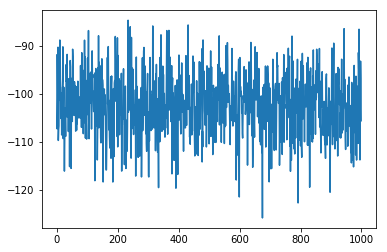

In [77]:
sampler.plot()